## Tesla Stock Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Using TensorFlow backend.
/Users/alfred/Library/Python/3.6/lib/python/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read csv file
dataframe = pd.read_csv('TSLA.csv')

In [3]:
dataframe.head()

,Time,First,Last
0,08/02/2010 09:00:00.000,20.40,20.74
1,08/02/2010 10:00:00.000,20.74,20.56
2,08/02/2010 11:00:00.000,20.59,20.65
3,08/02/2010 12:00:00.000,20.63,20.67
4,08/02/2010 13:00:00.000,20.68,20.68


### Convert Time into default pandas date time format

In [4]:
dataframe['Time']=pd.to_datetime(dataframe['Time'],infer_datetime_format=True)

In [5]:
dataframe.head()

,Time,First,Last
0,2010-08-02 09:00:00,20.40,20.74
1,2010-08-02 10:00:00,20.74,20.56
2,2010-08-02 11:00:00,20.59,20.65
3,2010-08-02 12:00:00,20.63,20.67
4,2010-08-02 13:00:00,20.68,20.68


### Take Average value of opening and closing stock for smoothness  

In [6]:
dataset = (0.5*(dataframe['First'] + dataframe['Last'])).values

In [7]:
print(dataset)

[ 20.57   20.65   20.62  ... 203.68  204.835 205.4  ]


### Scaling the dataset 

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1)) 

In [9]:
print(dataset)

[[0.01145074]
 [0.01174768]
 [0.01163632]
 ...
 [0.69110851]
 [0.69539558]
 [0.69749272]]


### Time delay function create time sequence of given delay

In [10]:
def timeDelay(data, delay):
    X_data, y_data = [], []
    #naive version, vectorized version can be implemented,
    #but may run out of memory,
    for i in range(delay, len(data)):
        X_data.append(data[i - (delay):i].tolist())
    X_data = np.array(X_data)
    #print(X_data)
    y_data = data[delay:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data),))

### Creating LSTM model

In [11]:
def model():
    model = Sequential()
    model.add(LSTM(4,input_shape=(5, 1), dropout=0.2))
    model.add(Dense(1))
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

### Define parameters

In [12]:
ratio = 0.8 # Training test ratio
d = 5 # Delay
X, y = timeDelay(dataset, d)
n = int(ratio * len(X))

In [13]:
X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

In [14]:
model = model()

Compilation Time :  0.017497777938842773


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
 - 2s - loss: 0.0696
Epoch 2/30
 - 1s - loss: 0.0165
Epoch 3/30
 - 2s - loss: 0.0099
Epoch 4/30
 - 1s - loss: 0.0086
Epoch 5/30
 - 1s - loss: 0.0075
Epoch 6/30
 - 1s - loss: 0.0068
Epoch 7/30
 - 1s - loss: 0.0065
Epoch 8/30
 - 1s - loss: 0.0062
Epoch 9/30
 - 1s - loss: 0.0063
Epoch 10/30
 - 1s - loss: 0.0054
Epoch 11/30
 - 1s - loss: 0.0056
Epoch 12/30
 - 1s - loss: 0.0053
Epoch 13/30
 - 2s - loss: 0.0050
Epoch 14/30
 - 2s - loss: 0.0048
Epoch 15/30
 - 1s - loss: 0.0046
Epoch 16/30
 - 1s - loss: 0.0049
Epoch 17/30
 - 1s - loss: 0.0041
Epoch 18/30
 - 2s - loss: 0.0039
Epoch 19/30
 - 2s - loss: 0.0035
Epoch 20/30
 - 2s - loss: 0.0037
Epoch 21/30
 - 2s - loss: 0.0035
Epoch 22/30
 - 2s - loss: 0.0030
Epoch 23/30
 - 2s - loss: 0.0028
Epoch 24/30
 - 2s - loss: 0.0028
Epoch 25/30
 - 2s - loss: 0.0025
Epoch 26/30
 - 2s - loss: 0.0026
Epoch 27/30
 - 2s - loss: 0.0029
Epoch 28/30
 - 2s - loss: 0.0025
Epoch 29/30
 - 2s - loss: 0.0025
Epoch 30/30
 - 2s - loss: 0.0027


In [17]:
baseline_testScore = scaler.inverse_transform(np.array([[mean_squared_error(y_test[10:], y_test[:-10])**.5]]))
trainScore = scaler.inverse_transform(np.array([[model.evaluate(X_train, y_train, verbose=0)**.5]]))
testScore = scaler.inverse_transform(np.array([[model.evaluate(X_test, y_test, verbose=0)**.5]]))

print('baseline test score = %.2f RMSE' % baseline_testScore)
print('train score = %.2f RMSE' % trainScore)
print('test score = %.2f RMSE' % testScore)

baseline test score = 24.17 RMSE
train score = 37.03 RMSE
test score = 50.35 RMSE


In [18]:
# generate predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [19]:
y = np.append(y_train, y_test)

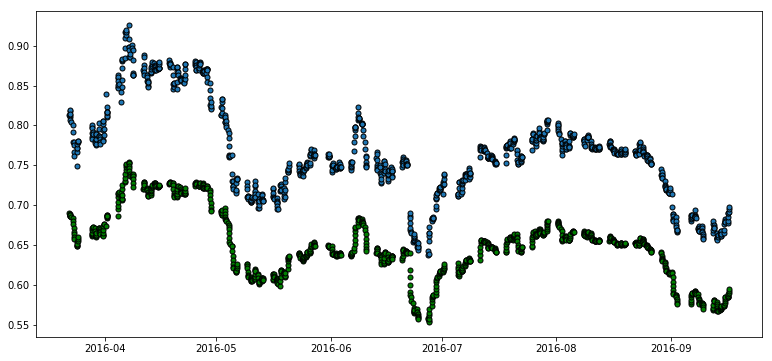

In [20]:
nn = 1000
plt.figure(figsize=(13, 6))
plt.plot(dataframe['Time'][3:][-nn:], np.append(y_train, y_test)[-nn:], 'o', ms=5,markeredgecolor='k')
#plt.plot(dataframe['Time'][3:][:n], y_train_pred, 'r')
plt.plot(dataframe['Time'][3:][n:][-nn:], y_test_pred[-nn:], 'o', ms=5, color='green',markeredgecolor='k')